# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import pandas as pd
import numpy as np
import glob, os
import random
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
idx = pd.IndexSlice

In [2]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

***

### Assumptions

In order to clean the data, we made the following assumptions : 
- A person, counted in one of the three categories (i.e. confirmed, suspect, probable) for deaths and cases, can't be counted in another category. This reasonnable assumption guarantees that we are not counting people multiple times when computing the means.
- As told during the lab session, we consider the Totals/National field for each country as consistent with respect to the different region/cities reports
- Cumulative description/variable (e.g. Total deaths of confirmed) are assumed to carry all items from previous days that has not been registered. More precisely, let d1 and d2 be two dates such that d1 < d2  and d2 - d1 > 1 (with respect to time). Then d2 contains information about the corresponding description from d1 + 1 to d2. 

***

### Loading the data for each country

In [3]:
def load_country(country_name):
    return pd.concat(map(pd.read_csv, glob.glob(r'' + DATA_FOLDER + '/ebola/' + country_name + '_data/*.csv')))

In [4]:
#Load the data into a dataframe for each country
guinea_dataframe = load_country('guinea')
liberia_dataframe = load_country('liberia')
sierraleone_dataframe = load_country('sl')

#Print columns label
print('Guinea:', guinea_dataframe.columns.get_values())
print('Liberia:', liberia_dataframe.columns.get_values())
print('Sierra Leone:', sierraleone_dataframe.columns.get_values())

Guinea: ['Beyla' 'Boffa' 'Conakry' 'Coyah' 'Dabola' 'Dalaba' 'Date' 'Description'
 'Dinguiraye' 'Dubreka' 'Forecariah' 'Gueckedou' 'Kerouane' 'Kindia'
 'Kissidougou' 'Kouroussa' 'Lola' 'Macenta' 'Mzerekore' 'Nzerekore' 'Pita'
 'Siguiri' 'Telimele' 'Totals' 'Yomou']
Liberia: ['Bomi County' 'Bong County' 'Date' 'Gbarpolu County' 'Grand Bassa'
 'Grand Cape Mount' 'Grand Gedeh' 'Grand Kru' 'Lofa County'
 'Margibi County' 'Maryland County' 'Montserrado County' 'National'
 'Nimba County' 'River Gee County' 'RiverCess County' 'Sinoe County'
 'Unnamed: 18' 'Variable']
Sierra Leone: ['34 Military Hospital' 'Bo' 'Bo EMC' 'Bombali' 'Bonthe' 'Hastings-F/Town'
 'Kailahun' 'Kambia' 'Kenema' 'Kenema (IFRC)' 'Kenema (KGH)' 'Koinadugu'
 'Kono' 'Moyamba' 'National' 'Police training School'
 'Police traning School' 'Port Loko' 'Pujehun' 'Tonkolili' 'Unnamed: 18'
 'Western area' 'Western area combined' 'Western area rural'
 'Western area urban' 'date' 'variable']


***

### Selecting the interesting descriptions/variables 

In [5]:
guinea_descriptions = set(guinea_dataframe.Description.values.tolist())
liberia_descriptions = set(liberia_dataframe.Variable.values.tolist())
sierraleone_descriptions = set(sierraleone_dataframe.variable.values.tolist())

print(len(guinea_descriptions))
print(len(liberia_descriptions))
print(len(sierraleone_descriptions))

60
45
37


In [6]:
# All possible descriptions for guinea
#print(guinea_descriptions)

# From which we decided to keep only the following descriptions
filtered_guinea_descriptions = ['New cases of confirmed', 
                                'New cases of suspects', 
                                'New cases of probables',
                                'Total deaths of confirmed',
                                'Total deaths of suspects',
                                'Total deaths of probables'];

# Rename dictionary that will be useful later
guinea_rename_dict = {'New cases of confirmed': 'cases confirmed',
                      'New cases of suspects': 'cases suspected',
                      'New cases of probables': 'cases probable',
                      'Total deaths of confirmed': 'deaths confirmed',
                      'Total deaths of suspects': 'deaths suspected',
                      'Total deaths of probables': 'deaths probable'}

For guinea, the descriptions 'New deaths registered today (probables)' and 'New deaths registered today (suspects)' or not really interesting as there are only available for one day and equal to 0. Moreover the description 'New deaths registered today (confirmed)' is also available during only one day and is a redundancy of the description 'New deaths registered today'. Thus we decided to drop those descriptions.

In [7]:
# All possible descriptions for liberia
#print(liberia_descriptions)

# From which we decided to keep only the following descriptions
filtered_liberia_descriptions = ['New case/s (confirmed)', 
                                 'New Case/s (Suspected)', 
                                 'New Case/s (Probable)',
                                 'Total death/s in confirmed cases',
                                 'Total death/s in suspected cases',
                                 'Total death/s in probable cases']

liberia_rename_dict = {'New case/s (confirmed)': 'cases confirmed',
                       'New Case/s (Suspected)': 'cases suspected',
                       'New Case/s (Probable)': 'cases probable',
                       'Total death/s in confirmed cases': 'deaths confirmed',
                       'Total death/s in suspected cases': 'deaths suspected',
                       'Total death/s in probable cases': 'deaths probable'}

In [8]:
# All possible descriptions for Sierra Leone
#print(sierraleone_descriptions)

# From which we decided to keep only the following descriptions
filtered_sierraleone_descriptions = ['death_confirmed', 
                                     'death_probable', 
                                     'death_suspected',
                                     'new_confirmed', 
                                     'new_probable', 
                                     'new_suspected']

sierraleone_rename_dict = {'death_confirmed': 'deaths confirmed',
                           'death_suspected': 'deaths suspected',
                           'death_probable': 'deaths probable',
                           'new_confirmed': 'cases confirmed',
                           'new_probable': 'cases probable',
                           'new_suspected': 'cases suspected'}

***

### Cleaning the dataframes

#### General cleaning

In [9]:
# Check for duplicates
print('Guinea has duplicates ?', True in guinea_dataframe.duplicated(subset=['Date', 'Description']).values)
print('Liberia has duplicates ?', True in liberia_dataframe.duplicated(subset=['Date', 'Variable']).values)
print('Sierra Leone has duplicates ?', True in sierraleone_dataframe.duplicated(subset=['date', 'variable']).values)

Guinea has duplicates ? False
Liberia has duplicates ? True
Sierra Leone has duplicates ? True


In [10]:
# Remove duplicates
liberia_dataframe = liberia_dataframe.drop_duplicates(['Date', 'Variable'])
sierraleone_dataframe = sierraleone_dataframe.drop_duplicates(['date', 'variable'])

In [11]:
# Keep only interesting columns
guinea_dataframe = guinea_dataframe[['Date', 'Description', 'Totals']]
liberia_dataframe = liberia_dataframe[['Date', 'Variable', 'National']]
sierraleone_dataframe = sierraleone_dataframe[['date', 'variable', 'National']]

# Standardize the date field for each dataframe
guinea_dataframe.Date = pd.to_datetime(guinea_dataframe.Date)
liberia_dataframe.Date = pd.to_datetime(liberia_dataframe.Date)
sierraleone_dataframe.date = pd.to_datetime(sierraleone_dataframe.date)

# Keep only the insteresting variables/descriptions
guinea_dataframe = guinea_dataframe[[des in filtered_guinea_descriptions for des in guinea_dataframe.Description]]
liberia_dataframe = liberia_dataframe[[var in filtered_liberia_descriptions for var in liberia_dataframe.Variable]]
sierraleone_dataframe = sierraleone_dataframe[[var in filtered_sierraleone_descriptions for var in sierraleone_dataframe.variable]]

# Remove rows with missing value
guinea_dataframe = guinea_dataframe.dropna()
liberia_dataframe = liberia_dataframe.dropna()
sierraleone_dataframe = sierraleone_dataframe.dropna()

# Cast all values to int
guinea_dataframe.Totals = guinea_dataframe.Totals.astype(int)
liberia_dataframe.National = liberia_dataframe.National.astype(int)
sierraleone_dataframe.National = sierraleone_dataframe.National.astype(int)

# Rename all reports (i.e. variable/description)
guinea_dataframe.Description = guinea_dataframe.Description.apply(lambda des: guinea_rename_dict[des]) 
liberia_dataframe.Variable = liberia_dataframe.Variable.apply(lambda var: liberia_rename_dict[var])
sierraleone_dataframe.variable = sierraleone_dataframe.variable.apply(lambda var: sierraleone_rename_dict[var])


#### Cleaning Guinea dataframe

After looking at the guinea dataframe, we noticed that the original 'Total deaths...' descriptions were cumulative values. We thus had to get the daily new deaths cases for each day. This is what is done in the cell below.

In [12]:
def clean_cum_guinea(des_name, df):
    r_df = df.copy()
    guinea_parts_to_clean = r_df[r_df.Description == des_name]
    guinea_parts_to_clean = guinea_parts_to_clean.set_index(['Date', 'Description']).sort_index()
    
    cleaned_guinea_parts = (guinea_parts_to_clean - guinea_parts_to_clean.shift(1))
    
    idx = pd.IndexSlice
    r_df = r_df.set_index(['Date', 'Description']).sort_index()
    r_df.loc[idx[:, [des_name]], :] = cleaned_guinea_parts
    r_df = r_df.dropna().reset_index()
    return r_df
    
guinea_dataframe = clean_cum_guinea('deaths confirmed', guinea_dataframe)
guinea_dataframe = clean_cum_guinea('deaths suspected', guinea_dataframe)
guinea_dataframe = clean_cum_guinea('deaths probable', guinea_dataframe)

Notice from the guinea dataframe below that **some reports yield negative values**. Unless they were giving unexpected average values, we generaly decided to interpret them as corrections on previous reports and thus keep them. 

In [13]:
guinea_dataframe.head()

,Date,Description,Totals
0,2014-08-04,cases confirmed,4.0
1,2014-08-04,cases probable,0.0
2,2014-08-04,cases suspected,5.0
3,2014-08-26,cases confirmed,10.0
4,2014-08-26,cases suspected,18.0


#### Cleaning Liberia dataframe

In [14]:
# Last record for in liberia_new_deaths_... is equal to 0 which is a dirty value as it should be greater than the value in the precedent record
# '...' here means {'confirmed', 'probable', 'suspected'}

liberia_dataframe = liberia_dataframe.set_index(['Date', 'Variable']).sort_index()

index0 = liberia_dataframe.loc[idx[:, 'deaths confirmed'], :][-1:].index
index1 = liberia_dataframe.loc[idx[:, 'deaths probable'], :][-1:].index
index2 = liberia_dataframe.loc[idx[:, 'deaths suspected'], :][-1:].index

liberia_dataframe = liberia_dataframe.drop(index0)
liberia_dataframe = liberia_dataframe.drop(index1)
liberia_dataframe = liberia_dataframe.drop(index2)

liberia_dataframe = liberia_dataframe.reset_index()

We can see, from the liberia datafame below, that some rows at the end are dirty as they switch to a cumulative fashion. 

In [15]:
liberia_dataframe[-30:].head()

,Date,Variable,National
415,2014-11-27,cases suspected,25
416,2014-11-28,cases confirmed,7
417,2014-11-29,cases confirmed,10
418,2014-11-29,cases probable,4
419,2014-11-29,cases suspected,7


In [16]:
# This cell deals with the cumulative values found at the end of the dataframe for certain reports

dirty_rows_liberia = liberia_dataframe[liberia_dataframe.Date > pd.datetime(2014, 12, 2)]
dirty_rows_liberia = dirty_rows_liberia.set_index(['Date', 'Variable']).sort_index()

cleaned_rows_liberia = dirty_rows_liberia - dirty_rows_liberia.shift(3)

liberia_dataframe = liberia_dataframe.set_index(['Date', 'Variable']).sort_index()
liberia_dataframe.loc[pd.datetime(2014, 12, 4):, :] = cleaned_rows_liberia
liberia_dataframe = liberia_dataframe.dropna().reset_index()

In [17]:
# This cell deals with cumulative records (similar to the guinea cleaning case)

def clean_cum_liberia(des_name, df):
    r_df = df.copy()
    liberia_parts_to_clean = r_df[r_df.Variable == des_name]
    liberia_parts_to_clean = liberia_parts_to_clean.set_index(['Date', 'Variable']).sort_index()
    
    cleaned_liberia_parts = (liberia_parts_to_clean - liberia_parts_to_clean.shift(1))
    
    idx = pd.IndexSlice
    r_df = r_df.set_index(['Date', 'Variable']).sort_index()
    r_df.loc[idx[:, [des_name]], :] = cleaned_liberia_parts
    r_df = r_df.dropna().reset_index()
    return r_df

liberia_dataframe = clean_cum_liberia('deaths confirmed', liberia_dataframe)
liberia_dataframe = clean_cum_liberia('deaths suspected', liberia_dataframe)
liberia_dataframe = clean_cum_liberia('deaths probable', liberia_dataframe)

#### Cleaning Sierra Leone dataframe

In [18]:
# This cell deals with cumulative values (similar to guinea and liberia cases)

sierraleone_dataframe_copy = sierraleone_dataframe.copy().set_index(['date', 'variable']).unstack()
tmp = sierraleone_dataframe.set_index(['date', 'variable']).unstack()
tmp = tmp.National[['deaths confirmed', 'deaths probable', 'deaths suspected']]
cleaned = (tmp - tmp.shift(1)).fillna(value=0)

sierraleone_dataframe_copy.National.loc[1:, ['deaths confirmed', 'deaths probable', 'deaths suspected']] = cleaned[1:]
sierraleone_dataframe = sierraleone_dataframe_copy.stack().reset_index()[3:]

In [19]:
# Remove first three lines 
sierraleone_dataframe = sierraleone_dataframe[3:]

***

### Aggregation and merging

In [20]:
# Keeps only the year and month of each report
guinea_dataframe['Period'] = guinea_dataframe.Date.dt.to_period('M')
liberia_dataframe['Period'] = liberia_dataframe.Date.dt.to_period('M')
sierraleone_dataframe['Period'] = sierraleone_dataframe.date.dt.to_period('M')

# Keep only the day number of the month. It will be necessary when computing the means
guinea_dataframe.Date = guinea_dataframe.Date.apply(lambda x: x.day)
liberia_dataframe.Date = liberia_dataframe.Date.apply(lambda x: x.day)
sierraleone_dataframe.date = sierraleone_dataframe.date.apply(lambda x: x.day)

# Add a country column to each dataframe. This is required to merge the 3 different dataframes.
guinea_dataframe['Country'] = 'Guinea'
liberia_dataframe['Country'] = 'Liberia'
sierraleone_dataframe['Country'] = 'Sierraleone'

In [21]:
# Compute averages for each month
averages_guinea_dataframe = pd.DataFrame(guinea_dataframe.groupby(['Country', 'Period', 'Description']).apply(lambda group: max(group['Totals'].sum() / group['Date'].max(), 0)))
averages_liberia_dataframe = pd.DataFrame(liberia_dataframe.groupby(['Country', 'Period', 'Variable']).apply(lambda group: group['National'].sum() / group['Date'].max()))
averages_sierraleone_dataframe = pd.DataFrame(sierraleone_dataframe.groupby(['Country', 'Period', 'variable']).apply(lambda group: group['National'].sum() / group['date'].max()))

# Remove index
averages_guinea_dataframe = averages_guinea_dataframe.reset_index()
averages_liberia_dataframe = averages_liberia_dataframe.reset_index()
averages_sierraleone_dataframe = averages_sierraleone_dataframe.reset_index()

# Rename columns
averages_guinea_dataframe.columns = ['country', 'date', 'report', 'average']
averages_liberia_dataframe.columns = ['country', 'date', 'report', 'average']
averages_sierraleone_dataframe.columns = ['country', 'date', 'report', 'average']

# Stack all averages into one dataframe
all_averages_dataframe = pd.concat([averages_guinea_dataframe, averages_liberia_dataframe, averages_sierraleone_dataframe])

# Sort final dataframe, set index and unstack result (for readibility reasons)
all_averages_dataframe = all_averages_dataframe.sort_values(['date']).set_index(['country', 'date', 'report']).unstack()


In [22]:
all_averages_dataframe

average                                 \
report              cases confirmed cases probable cases suspected   
country     date                                                     
Guinea      2014-08        2.000000       0.258065        1.903226   
            2014-09        6.933333       0.633333        2.900000   
            2014-10        6.000000       0.000000       28.000000   
Liberia     2014-06        0.517241       0.275862        0.586207   
            2014-07        0.769231       1.576923        1.269231   
            2014-08        1.750000       6.357143        3.857143   
            2014-09        4.933333      23.466667       22.666667   
            2014-10        1.360000      14.322581       21.322581   
            2014-11        1.300000       3.620690        8.724138   
            2014-12        9.888889       2.222222        4.333333   
Sierraleone 2014-08       11.612903       0.709677        3.193548   
            2014-09       33.266667       0.000000        6.275862   
            2014-10       51.225806       0.774194       12.064516   
            2014-11       43.379310       0.000000       11.103448   
            2014-12       32.600000       0.000000        8.400000   

                                                                       
report              deaths confirmed deaths probable deaths suspected  
country     date                                                       
Guinea      2014-08         3.516129        0.548387         0.000000  
            2014-09         6.733333        0.833333         6.423077  
            2014-10        23.000000        2.000000         0.000000  
Liberia     2014-06         0.620690        0.137931         0.379310  
            2014-07         1.538462        1.923077         0.230769  
            2014-08         9.107143       10.357143         6.964286  
            2014-09        20.233333       10.833333         8.033333  
            2014-10        20.090909        6.857143         8.714286  
            2014-11              NaN             NaN              NaN  
            2014-12              NaN             NaN              NaN  
Sierraleone 2014-08         3.967742        0.096774         0.193548  
            2014-09         5.433333        0.000000         0.000000  
            2014-10        16.774194        5.516129         4.709677  
            2014-11        14.689655        0.000000         0.034483  
            2014-12        35.333333        0.000000         0.000000

***

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [23]:
#Extract metadata
metadata = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls')

MIDs={};            
MID_combined={};

# load MID1-MID9 files
for i in range(1,10):
    # parse the DataFrame with metavalues
    group_str = str(metadata[metadata.BARCODE == ('MID'+str(i))]['GROUP'].values[0]); #e.g. NEC1
    sample_str = str(metadata[metadata.BARCODE == ('MID'+str(i))]['SAMPLE'].values[0]); #stool or tissue
    if(sample_str == 'nan'):
        sample_str='unknown';
    # prase excel with column values 'NAME' and sample_str
    MIDs[i-1] = pd.read_excel(DATA_FOLDER+'/microbiome/MID'+str(i)+'.xls', sheetname='Sheet 1', header=None, names=['NAME',sample_str])
    #add 1 more level with 'group_str'
    MIDs[i-1].columns = pd.MultiIndex.from_arrays([MIDs[i-1].columns, ['',group_str ]])

    
# Merge the DataFrames together
MID_combined = MIDs[0];
for i in range(1,9):
    MID_combined = pd.DataFrame.merge(MID_combined, MIDs[i], how='outer')

# Setting all NaN to 'unknown' label
MID_combined = MID_combined.fillna('unknown')
MID_combined.set_index('NAME', inplace=True)

# Checking if the Index is unique
print('Is the "NAME" index unique ? : ' + str(MID_combined.index.is_unique))

# Printing some values
MID_combined.head()

Is the "NAME" index unique ? : True


unknown tissue  \
                                                   EXTRACTION CONTROL  NEC 1   
NAME                                                                           
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7     23   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  2      2   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...                  3     10   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...                  3      9   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  7      9   

                                                                       \
                                                   Control 1    NEC 2   
NAME                                                                    
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        14        2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown  unknown   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...         4  unknown   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...         5  unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         7        1   

                                                             stool            \
                                                   Control 2 NEC 1 Control 1   
NAME                                                                           
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        28     7         8   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         3     2         1   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...        14     5         5   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...        10     4         5   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...        17    12        18   

                                                                       
                                                      NEC 2 Control 2  
NAME                                                                   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown        16  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown  
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...        1         6  
Archaea "Crenarchaeota" Thermoprotei Thermoprot...  unknown         5  
Archaea "Euryarchaeota" "Methanomicrobia" Metha...  unknown        14

# Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

### 3.0 <span style="color:Green"> Importing the data </span>

In [24]:
df = pd.read_excel(DATA_FOLDER + '/titanic.xls', sheetname='titanic', header=0)
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


### Visualizing the Raw DataFrame

In [25]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

--------------------------------

## 3.1<span style="color:Green"> Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.</span>

### Describing the Data

- *pclass*: The type is integer since, as indicated, there are three types of pclasses namely: 1, 2, and 3. Thus the range is from 1 to 3 with discrete integerers. It can be set to categorical.

- *survived*: The type is also integer as the passenger can either survive ('True') which corresponds to 1 or die ('False') which corresponds to 0. Can be categorical.

- *name*: String since these are the names of the passengers. Can't be categorical due to the fact that there are many possibilities to what the name can be.

- *sex*: A string referring to the sex of the passenger and thus having only two possibilities; "Male" or "Female".

- *age*: Double or float since one's age is continuous and not discrete. The range is from 0 to the maximum age of a passenger (will assume 100). As it's continuous, it's not categorical.

- *slbsp*: Since it represents the number of siblings, it should be an integer as it only can indicate full numbers. It ranges from 0 to max number of siblings a person has onboard. In this case, it's 8. Can be categorical, but it becomes a bit repetitive and thus should be kept non categorical. 

- *parch*: Since it represents the number of parents and children, it should be an integer as it only can indicate full numbers. It can range from 0 to max number of children a parent can have onboard. In this case, it's 9. Also kept non-categorical.

- *ticket*: The type is object since it represents a string as ticket stands for ticket number. Since not all the ticket numbers are actual integers and some contain characters, the type is string and not integer.Non-categorical.

- *fare*: This is the fare of the ticket in the British Pound currency. It's a float number and ranges from 0 to a high number. Since it's continuous, it can't be categorical.

- *cabin*: The type of this attribute is String since it contains the cabin number along with the floor. 
    - *cabin floor*: The letter indicating the floor number. It is categorical.
    
- *embarked*: This attribute refers to a String representing the embarcation location with 3 values.: C, Q, S. In the spreadsheet, you can't tell what these values stand for. However, taking a look at the HTML file, we can see that these stand for Cherbourg, Queenstown, and Southhampton, respectively. Thus, it can be categorical. 

- *boat*: This attribute is an integer. Noticing that whenever the survived value for a passenger is 0 which means he hasn't survived, the boat attribute takes a NAN value. This means that the attribute refers to the boat id the survived passenger took. Ranges from???????

- *body*: A float numerical refering to the body id number of the dead passenger. Its range might be from 1 to the number of dead passengers/identified dead bodies. 

- *home.dest*: String indicating the home and final destination of the passenger. Not categorical

### Cleaning Data and Transforming Categorical Data

Firstly, before even trying to manipulate and plot the data, we should make sure that the data is clean: the claims that were made previously are true. Moreover, we should know what should be done with any missing data.

*pclass:* We have no missing data. We also approve that there are only three categories:

In [26]:
print("The unique categories should be: {1,2,3}")
print('The actual unique categories in the data given are: {}'.format(df['pclass'].unique()))
print("Number of missing data for 'pclass' attribute: " + str(np.sum(pd.isnull(df['pclass']))))
df["pclass"] = df["pclass"].astype('category')

The unique categories should be: {1,2,3}
The actual unique categories in the data given are: [1 2 3]
Number of missing data for 'pclass' attribute: 0


*survived:* Again, we have no missing data. We also approve that there are only two categories. This attribute can be transformed into categorical, but we won't do it since we need it as non-categorical when we want to calculate the proportion of the passengers that survived by travel class and sex. This is because the factor plot inputs must contain one non-categorical input.

In [27]:
print("The unique categories should be: {0,1}")
print('The actual unique categories in the data given are: {}'.format(df['survived'].unique()))
print("Number of missing data for 'survived' attribute: " + str(np.sum(pd.isnull(df['survived']))))


The unique categories should be: {0,1}
The actual unique categories in the data given are: [1 0]
Number of missing data for 'survived' attribute: 0


*sex:* No missing data. Also, all the values are either "Male" or "Female"

In [28]:
print("The unique categories should be: {\"Male\",\"Female\"}")
print('The actual unique categories in the data given are: {}'.format(df['sex'].unique()))
print("Number of missing data for 'sex' attribute: " + str(np.sum(pd.isnull(df['sex']))))
df["sex"] = df["sex"].astype('category')

The unique categories should be: {"Male","Female"}
The actual unique categories in the data given are: ['female' 'male']
Number of missing data for 'sex' attribute: 0


*age:* We have 263 NaN values (missing data) for passenger ages. We also calculate the range of the numerical attribute. There are 12 age values less than 1, therefore we know that it us not an error. Additionally, we apply a (to-month) transformation to them and we obtain values between 1 and 11 included. This assures that the values represent month ages. In order not to create an additional DATAFRAME, we will keep the NaN values untouched for the time being. Later on, when we want to plot, we can drop them.

In [29]:
print("Number of missing data for 'age' attribute: " + str(np.sum(pd.isnull(df['age']))))
print("Range of the 'age' attribute: [" + str(df['age'].min()) +', ' +  str(df['age'].max()) + "] years." )
# We would also like to check whether there are a significant number of ages less than 1 to see whether 
#it's an error or if it represents a baby of age less than 1.
print("Number of ages less than 1: " + str(len([x for x in df['age'] if x<1])) + " occurences.")
print("The below values are in years:\n " + str(df[df['age']<1]['age']) + " \nWhile the ones below are in months: \n" + str(np.round(df[df['age']<1]['age']*12)))

Number of missing data for 'age' attribute: 263
Range of the 'age' attribute: [0.1667, 80.0] years.
Number of ages less than 1: 12 occurences.
The below values are in years:
 1       0.9167
359     0.8333
427     0.6667
548     0.8333
590     0.9167
611     0.8333
657     0.7500
658     0.7500
747     0.3333
763     0.1667
1111    0.7500
1240    0.4167
Name: age, dtype: float64 
While the ones below are in months: 
1       11.0
359     10.0
427      8.0
548     10.0
590     11.0
611     10.0
657      9.0
658      9.0
747      4.0
763      2.0
1111     9.0
1240     5.0
Name: age, dtype: float64


*sibsp* and *parch*: We calculate the range of these values and check how many missing entries there are.


In [30]:
print("Number of missing data for 'sibsp' attribute: " + str(np.sum(pd.isnull(df['sibsp']))))
print("Range of the 'sibsp' attribute: [" + str(df['sibsp'].min()) +', ' +  str(df['sibsp'].max()) + "] persons." )
print("Number of missing data for 'parch' attribute: " + str(np.sum(pd.isnull(df['parch']))))
print("Range of the 'sibsp' attribute: [" + str(df['parch'].min()) +', ' +  str(df['parch'].max()) + "] persons." )

Number of missing data for 'sibsp' attribute: 0
Range of the 'sibsp' attribute: [0, 8] persons.
Number of missing data for 'parch' attribute: 0
Range of the 'sibsp' attribute: [0, 9] persons.


*cabins* and *floors:* The cabin number is made up of a letter followed by a number. Logically, the first letter represents the floor in the ship, and the number represents the room in that specific floor. In order to associate the data against the attribute *floor*, we have to create the new attribute *floors*, or at least try and see its possible values.  Also, we keep the NaN values untouched at the moment, and will treat them later before plotting. We have to note that there are 1014 missing data entries for cabin, so the data left is not very representative but might provide us with some insight. 

Additionally, we can observe from the HTML file that some cabin entries start with two letters such as *F E46*. Since these are categorized along with the other F values, we assume that this is a cabin located in floor F but also extending to floor E. This is probably because it's a duplex suite. We will disregard the fact that it extends to two floors and assume that the floor corresponding to such cabins is the first letter. 

In [31]:
df['floors'] = np.NaN # Created a new column in our dataframe called 'floors' and filled it with NaN.
for s in df.loc[df['cabin'].notnull()]['floors'].index: # For each non-Nan value of cabin, we took the initial of the cabin number
                                                        # and placed it in its corresponding row in the 'floors' column.
    initial = str(df.loc[s,'cabin'])[0]
    df.loc[s,'floors']=initial
df["floors"] = df["floors"].astype('category')
print(df['floors'].head())
print("The possible floors in the ship are: " + str(((df['floors'].dropna().unique()))) )   
print("However, the number of missing data for 'cabin' attribute: " + str(np.sum(pd.isnull(df['cabin']))))

0    B
1    C
2    C
3    C
4    C
Name: floors, dtype: category
Categories (8, object): [A, B, C, D, E, F, G, T]
The possible floors in the ship are: [B, C, E, D, A, T, F, G]
Categories (8, object): [B, C, E, D, A, T, F, G]
However, the number of missing data for 'cabin' attribute: 1014


*embarked*: As we previously mentioned, we expect that the values for *embarked* be S, Q, or C. We checked that here. We also found that there are only 2 missing values. We will, as done before, keep them untouched.

In [32]:
print("The unique categories should be: {S,Q,C}")
print('The actual unique categories in the data given are: {}'.format(df['embarked'].dropna().unique()))
print("Number of missing data for 'embarked' attribute: " + str(np.sum(pd.isnull(df['embarked']))))
df["embarked"] = df["embarked"].astype('category')

The unique categories should be: {S,Q,C}
The actual unique categories in the data given are: ['S' 'C' 'Q']
Number of missing data for 'embarked' attribute: 2


------------------------------------------

## 3.2  <span style="color:Green">Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.</span>

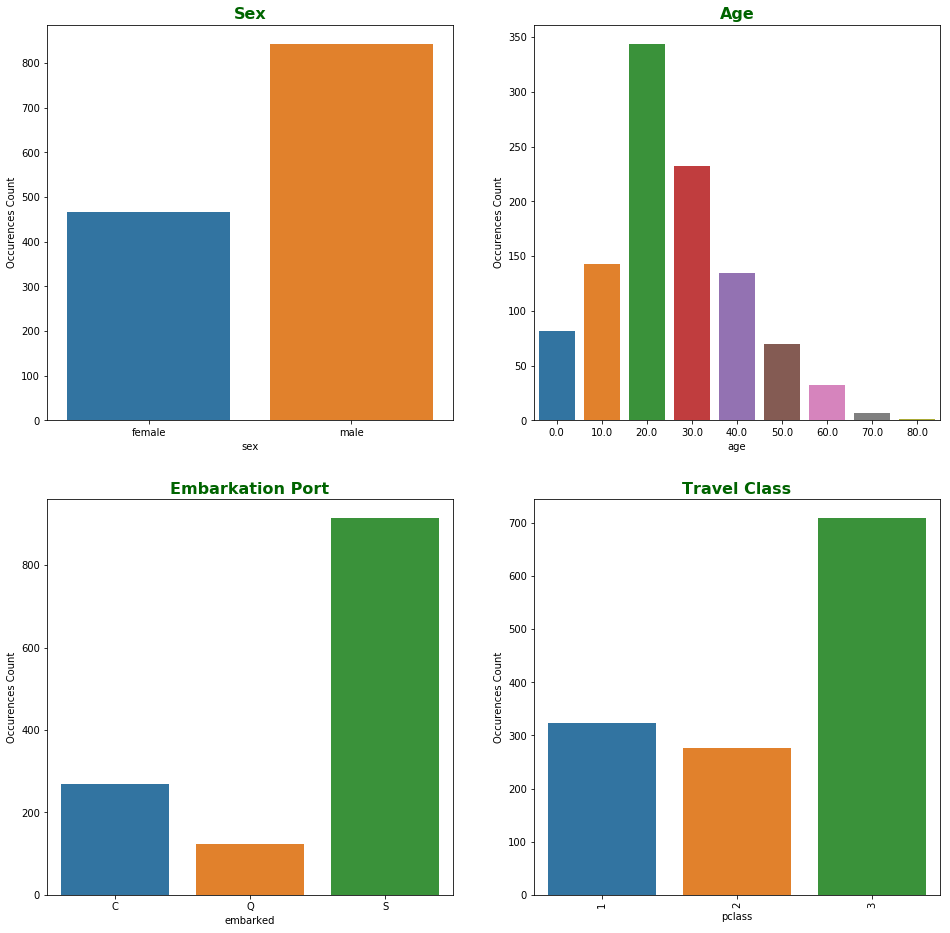

In [33]:
def nice_bar_plot(data, ax, title='', y_axis=''):
    ax.set_title(title , fontsize=16, fontweight='bold',color = 'darkgreen')
    ax.set_xlabel(data.name); ax.set_ylabel(y_axis)
    sns.barplot(x=data.value_counts().keys().values, y=data.value_counts().values,  ax=ax)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
fig, axes = plt.subplots(2, 2, figsize=(16,16))
nice_bar_plot(df['sex'], axes[0,0],'Sex', 'Occurences Count')
nice_bar_plot(np.floor(df['age'].divide(10))*10, axes[0,1],'Age', 'Occurences Count')
nice_bar_plot(df['embarked'], axes[1,0],'Embarkation Port', 'Occurences Count')
nice_bar_plot(df['pclass'], axes[1,1],'Travel Class', 'Occurences Count')
plt.show()

## 3.3 <span style="color:Green">Calculate the proportion of passengers by cabin floor. Present your results in a pie chart. </span>

As previously mentioned, we have around 1000 missing values for both *cabin* and *floors* making the following proportions not very reliable. 

It is worthy to note that around 77.4637127578% of the data is missing.


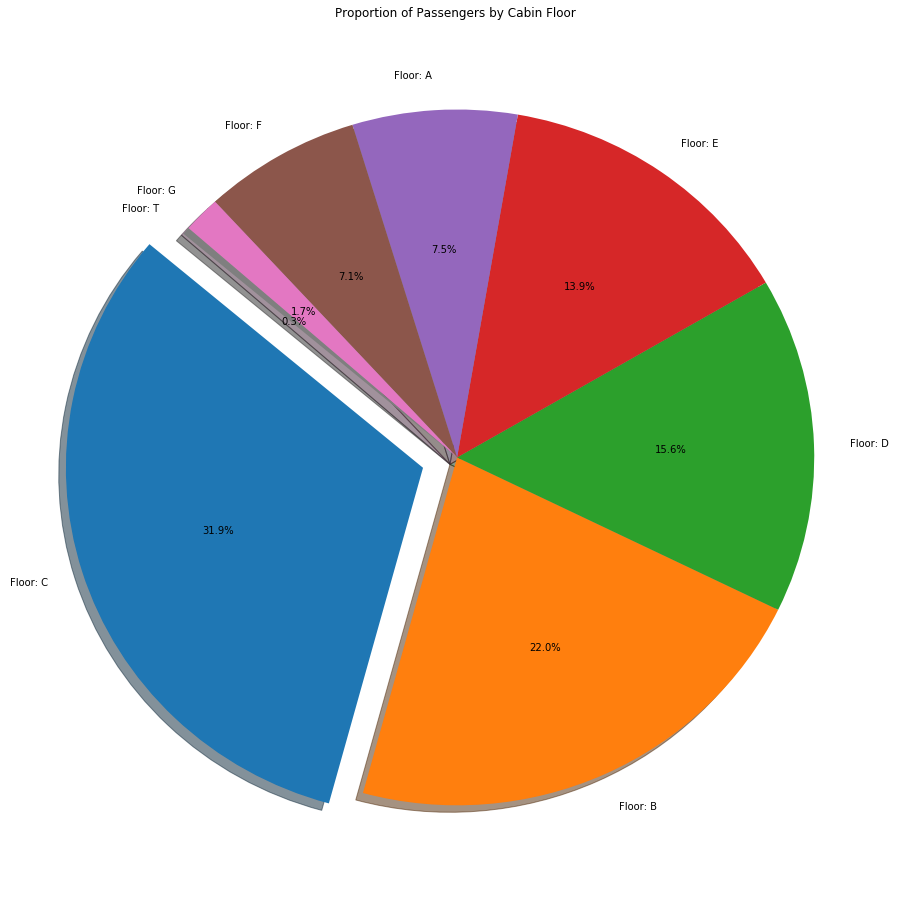

In [34]:
print("It is worthy to note that around " + str(np.sum(df['cabin'].isnull())/(len(df['cabin']))*100) + "% of the data is missing.")
fig, axes = plt.subplots(1, 1, figsize=(16,16))
ay = plt.subplot(1, 1, 1)
labels = ['Floor: ' + s for s in df['floors'].value_counts().keys().values]
explode = [0.1,0,0,0,0,0,0,0]
plt.pie(df['floors'].value_counts().values, labels=labels,explode = explode,shadow=True, startangle = 140,autopct='%1.1f%%' )
plt.title("Proportion of Passengers by Cabin Floor ")
plt.show()

## 3.4 <span style="color:Green">For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts. </span>

As we don't have any missing data in either the "Survived" attribute or "Pclass" attribute, we can say that the data shown is a good representative. Additionally, we can see that the lower the passenger class (higher value in DataFrame), the lower the survival rate. This is logical as first class cabins might provide better escape plans. Also, it's probable that the priority has been given to first class passengers. To better visualize the survival rate - passenger class relation, we can take a look at the plot in axes[1,1]. The relation is almost perfectly linear.

In class: 1 The percentage of people who survived (1) and didn't survive (0) is: 
0    38.080495
1    61.919505
Name: survived, dtype: float64
In class: 2 The percentage of people who survived (1) and didn't survive (0) is: 
0    57.039711
1    42.960289
Name: survived, dtype: float64
In class: 3 The percentage of people who survived (1) and didn't survive (0) is: 
0    74.471086
1    25.528914
Name: survived, dtype: float64
[0.61919504643962853, 0.4296028880866426, 0.25528913963328631]


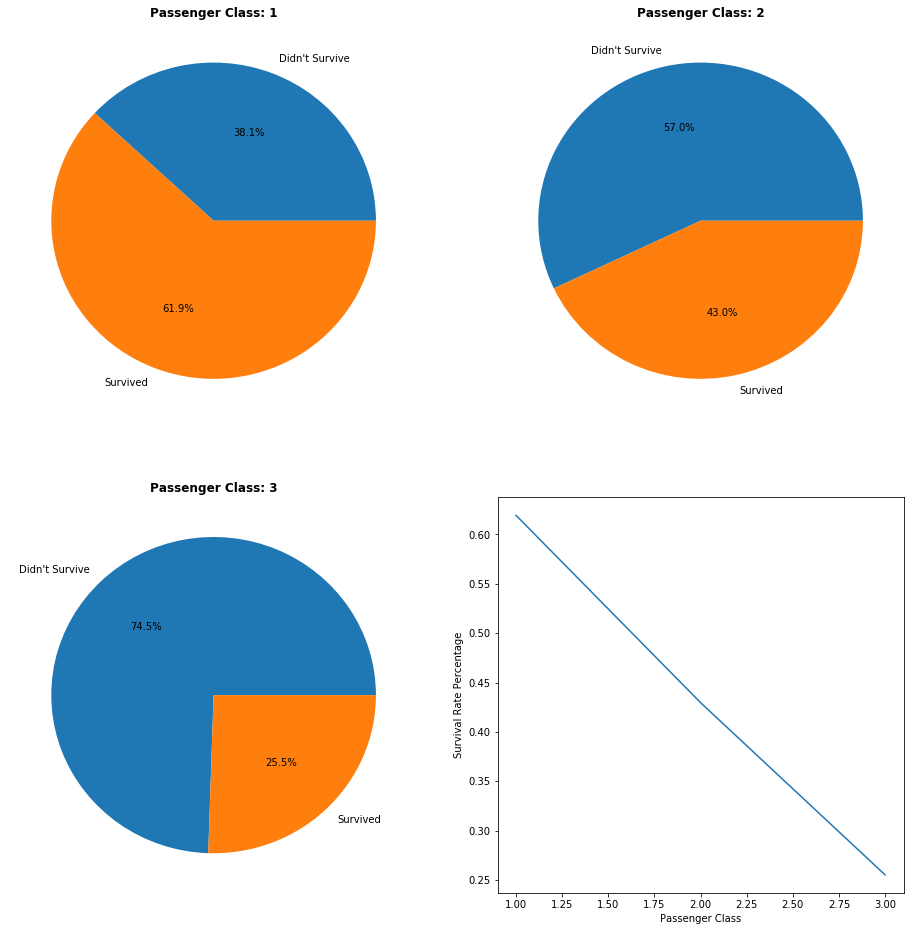

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
df[df['pclass']==1]['survived'].value_counts().values
i=1
#for s in set(df['pclass'].value_counts().keys().values):
#    print(df[df['pclass']==s]['survived'].value_counts())
for s in set(df['pclass'].value_counts().keys().values):
        print("In class: " + str(s) + " The percentage of people who survived (1) and didn't survive (0) is: " + 
              "\n" + str((df[df['pclass']==s]['survived'].value_counts(sort=False)).
              divide((df[df['pclass']==s]['survived'].value_counts(sort=False).sum()))*100))
        ay = plt.subplot(2, 2, i)
        ay.set_title("Passenger Class: " + str(s) , fontsize=12, fontweight='bold')
        plt.pie(df[df['pclass']==s]['survived'].value_counts(sort=False).values,autopct='%1.1f%%', labels = ["Didn't Survive", "Survived"])
        i = i+1
survivearray = []       
for s in range(1,4):
    
    a = df[df['pclass']==s]['survived'].value_counts(sort=False).divide((df[df['pclass']==s]['survived'].value_counts(sort=False).sum()))[1]
    survivearray.append(a)
   
    
print(survivearray)
ax = plt.subplot(2, 2, 4)

plt.plot([1.0,2.0,3], survivearray)
ax.set_xlabel("Passenger Class")
ax.set_ylabel("Survival Rate Percentage")
plt.show()



## 3.5 <span style="color:Green">Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram. </span>

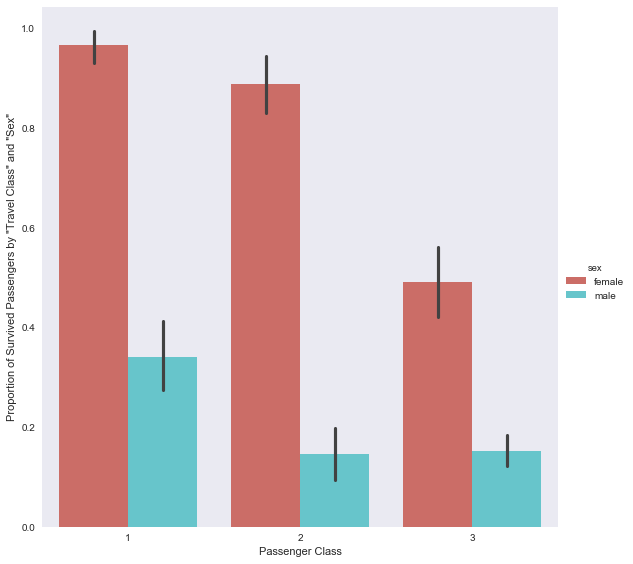

In [36]:
sns.set(style="dark")
gplot = sns.factorplot("pclass", "survived", "sex", data=df, size=8, kind="bar", palette="hls")
gplot.set_ylabels("Proportion of Survived Passengers by \"Travel Class\" and \"Sex\"")
gplot.set_xlabels("Passenger Class")
plt.show()

## 3.6 <span style="color:Green">Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.</span>

Firstly, we need to split the age attribute into two equally populated categories based on the median. To avoid further complexities related to running the median operation a second time on the categorical age, we create an additional attribute *agecat* containing the categorical age. 

However, we notice that after splitting, the two categories are not exactly equally populated with 536 passengers in the first category and 510 in the second. This is due to the fact that there are many people with the age 28. This problem is unavoidable, given that you can't categorize people with the age 28 into two different categories. 

In [37]:
df['agecat'] = pd.cut(df.age, [0, df['age'].median(), df['age'].max()])
df['agecat'].value_counts()

(0.0, 28.0]     536
(28.0, 80.0]    510
Name: agecat, dtype: int64

In [38]:
counts = df.groupby(['agecat', 'sex', 'pclass'])['survived'].agg(['count'])['count']
t = df.groupby(['agecat', 'sex', 'pclass'])['survived'].sum() #Since survived gives a 1 and the opposite gives 0, we can use
                                                           #sum() to calculate the number of people who survived, grouped by age,
                                                           #sex, and passenger class.
df_SurvivalRate = pd.DataFrame(t.divide(counts)*100)
print('Index is unique ? ', df_SurvivalRate.index.is_unique)
df_SurvivalRate

Index is unique ?  True


0
agecat       sex    pclass           
(0.0, 28.0]  female 1       95.121951
                    2       91.071429
                    3       51.376147
             male   1       53.125000
                    2       21.621622
                    3       18.303571
(28.0, 80.0] female 1       96.739130
                    2       87.234043
                    3       37.209302
             male   1       30.252101
                    2        8.333333
                    3       14.400000